# Machine Learning Modelle
1. [Entfernung von zukunftsbezogenen Features](#1)
1. [Erstellung eines Random Forest-Modells](#2)
  1. [Permutation Importance](#3)
  1. [F-Score](#4)
1. [Erstellung eines XGBoost-Modells](#5)
1. [Performance-Vergleich von ARIMA, Random Forest und XGBoost](#6)
1. [Weitere Modelle testen](#7)

In [92]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from xgboost import XGBRegressor

plt.style.use('ggplot')

print("Setup complete")

Setup complete


In [93]:
def add_lag_features(dataframe, columns):
    """
    Fügt einem DataFrame Verzögerungs-Features (Lags) für die angegebenen Spalten hinzu. 
    Für jede Spalte in 'columns' wird ein Verzögerungs-Feature hinzugefügt.
    Jedes Verzögerungs-Feature ist eine Verschiebung der Originalspalte um einen Schritt.

    :param dataframe: Pandas DataFrame, zu dem die Verzögerungs-Features hinzugefügt werden sollen.
    :param columns: Liste der Spaltennamen, für die Verzögerungs-Features erstellt werden sollen.
    :return: DataFrame mit den zusätzlichen Verzögerungs-Features.
    """
    lagged_df = dataframe.copy()
    for column in columns:
        lagged_df[f'{column}_lag'] = lagged_df[column].shift(1)
    return lagged_df


def add_use_lags(df, lag_hours):
    df_lagged = df.copy()
    for lag in lag_hours:
        df_lagged[f'use_lag_{lag}'] = df_lagged.use.shift(lag)
    return df_lagged


def print_metrics(actual, predicted):
    """
    Berechnet MAE, RMSE und MAPE zwischen den tatsächlichen und vorhergesagten Werten.
    :param actual: Array der tatsächlichen Werte
    :param predicted: Array der vorhergesagten Werte
    """
    actual, predicted = np.array(actual), np.array(predicted)

    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mape = mean_absolute_percentage_error(actual, predicted) * 100

    print(f"MAE: {round(mae, 2)}, RMSE: {round(rmse, 2)}, MAPE: {round(mape, 2)} %")

In [94]:
df = pd.read_csv("../input/2024-01-12/austin10_hourly.csv")
df = df[df.dataid == 1642].drop('dataid', axis=1)
df.timestamp = pd.to_datetime(df.timestamp)
df.set_index('timestamp', inplace=True)

df.head()

,use,construction_year,n_residents,n_rooms,total_area,outdoor_temp,app_outdoor_temp,humidity,hour,day,...,oven,n_oven,range,n_range,refrigerator,n_refrigerator,utilityroom,n_utilityroom,venthood,n_venthood
timestamp,,,,,,,,,,,,,,,,,,,,,
2018-01-01 06:00:00,0.58575,2007,3,11,159.79,-4.06,-7.56,0.69,6,1,...,0.008,1,NaN,0,NaN,0,NaN,0,NaN,0
2018-01-01 07:00:00,0.43750,2007,3,11,159.79,-4.22,-8.04,0.67,7,1,...,0.008,1,NaN,0,NaN,0,NaN,0,NaN,0
2018-01-01 08:00:00,0.47875,2007,3,11,159.79,-4.54,-8.38,0.65,8,1,...,0.008,1,NaN,0,NaN,0,NaN,0,NaN,0
2018-01-01 09:00:00,0.52275,2007,3,11,159.79,-4.48,-8.12,0.64,9,1,...,0.008,1,NaN,0,NaN,0,NaN,0,NaN,0
2018-01-01 10:00:00,0.41825,2007,3,11,159.79,-4.07,-7.35,0.63,10,1,...,0.008,1,NaN,0,NaN,0,NaN,0,NaN,0


In [95]:
# Fehlende Datenpunkte ergänzen --> sind dann erstmal NaN
df = df.asfreq('H', method='pad') # Pad muss eigentlich raus

<a id="1"></a>
## 1. Entfernung von zukunftsbezogenen Features
Ist es korrekt, man diese zur Vermeidung von Data Leakage nicht verwenden darf?

In [96]:
# Spalten entfernen, in denen jeder Wert identisch ist
cols_to_drop = [col for col in df.columns if df[col].nunique() <= 1]
df.drop(cols_to_drop, axis=1, inplace=True)

future_features = ['outdoor_temp', 'app_outdoor_temp', 'humidity', 'air', 'bathroom', 'car', 'clotheswasher', 'dishwasher', 'drye',
                   'dryg', 'furnace', 'kitchenapp', 'livingroom', 'microwave', 'oven', 'refrigerator', 'utilityroom', 'venthood']

# Verzögerungs-Features hinzufügen und zukunftsbezogene Features entfernen --> Um Data Leakage zu verhindern
df = add_lag_features(df, future_features)
df.drop(future_features, axis=1, inplace=True)

# Verzögerungs-Features für Spalte use für relevante Zeiten aus der Vergangenheit (nur für use, da sonst zu viele Features)
lag_hours = [1, 2, 3, 24, 48, 72]
df = add_use_lags(df, lag_hours)

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8760 entries, 2018-01-01 06:00:00 to 2019-01-01 05:00:00
Freq: H
Data columns (total 38 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   use                   8760 non-null   float64
 1   hour                  8760 non-null   int64  
 2   day                   8760 non-null   int64  
 3   month                 8760 non-null   int64  
 4   n_bathroom            8760 non-null   int64  
 5   n_clotheswasher       8760 non-null   int64  
 6   n_dryg                8760 non-null   int64  
 7   n_furnace             8760 non-null   int64  
 8   n_kitchenapp          8760 non-null   int64  
 9   n_livingroom          8760 non-null   int64  
 10  n_microwave           8760 non-null   int64  
 11  n_refrigerator        8760 non-null   int64  
 12  n_utilityroom         8760 non-null   int64  
 13  n_venthood            8760 non-null   int64  
 14  outdoor_temp_lag      8757 n

In [97]:
# Prozentsatz der fehlenden Werte für jede Spalte
missing_share = df.isnull().mean() * 100

# Maximale Länge der Spaltennamen
max_column_name_len = max(len(column) for column in df.columns)

for column_name, percent_val in missing_share.items():
    if percent_val > 0:
        print(f"{column_name.ljust(max_column_name_len)}\t{percent_val:.2f}%")

outdoor_temp_lag    	0.03%
app_outdoor_temp_lag	0.03%
humidity_lag        	0.03%
air_lag             	0.01%
bathroom_lag        	3.46%
car_lag             	0.01%
clotheswasher_lag   	3.46%
dishwasher_lag      	3.46%
drye_lag            	0.01%
dryg_lag            	3.46%
furnace_lag         	3.46%
kitchenapp_lag      	3.46%
livingroom_lag      	3.46%
microwave_lag       	3.46%
oven_lag            	0.01%
refrigerator_lag    	3.46%
utilityroom_lag     	3.46%
venthood_lag        	3.46%
use_lag_1           	0.01%
use_lag_2           	0.02%
use_lag_3           	0.03%
use_lag_24          	0.27%
use_lag_48          	0.55%
use_lag_72          	0.82%


### Da pro Feature weniger als 5 Prozent der Daten fehlen, wird ein SimpleImputer verwendet

In [98]:
train_data, test_data = train_test_split(df, train_size=0.8, shuffle=False)

train_y = train_data.use
train_X = train_data.drop('use', axis=1)
test_y = test_data.use
test_X = test_data.drop('use', axis=1)

<a id="2"></a>
## 2. Erstellung eines Random Forest-Modells
"Für das systematische Tuning können Sie GridSearchCV oder RandomizedSearchCV aus Scikit-Learn verwenden."

In [99]:
# missing_cols = missing_share[(missing_share > 0)].index.tolist()

# simple_imputer = SimpleImputer(strategy='median')

# preprocessor = ColumnTransformer(transformers=[('simple', simple_imputer, missing_cols)])

# pipeline = Pipeline(steps=[('preprocessor', preprocessor),
#                            ('regressor', RandomForestRegressor(random_state=1))])

In [100]:
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('regressor', RandomForestRegressor(random_state=1))
])

# Anzahl der Bäume im Wald
n_estimators = np.arange(50, 1000, 50)
# Anzahl der Features, die bei der Suche nach dem besten Split berücksichtigt werden sollen
max_features = [None, 'sqrt', 'log2']
# Maximale Tiefe der Bäume
max_depth = np.arange(10, 100, 10)
# Minimale Anzahl von Samples, die benötigt werden, um einen internen Knoten zu teilen
min_samples_split = np.arange(2, 10, 1)
# Minimale Anzahl von Samples, die ein Blattknoten haben muss
min_samples_leaf = np.arange(1, 10, 1)
# Ob Bootstrap-Proben beim Aufbau der Bäume verwendet werden sollen
bootstrap = [True, False]

param_grid = {'regressor__n_estimators': n_estimators,
               'regressor__max_features': max_features,
               'regressor__max_depth': max_depth,
               'regressor__min_samples_split': min_samples_split,
               'regressor__min_samples_leaf': min_samples_leaf,
               'regressor__bootstrap': bootstrap}

rf = RandomizedSearchCV(estimator=pipeline, param_distributions=param_grid, n_iter=100, cv=3, verbose=0, random_state=1, n_jobs = -1)

rf.fit(train_X, train_y)

best_model = rf.best_estimator_

predictions = best_model.predict(test_X)

print_metrics(test_y, predictions)

MAE: 0.44, RMSE: 0.7, MAPE: 59.77 %


In [101]:
rf.best_params_

{'regressor__n_estimators': 700,
 'regressor__min_samples_split': 2,
 'regressor__min_samples_leaf': 5,
 'regressor__max_features': 'sqrt',
 'regressor__max_depth': 90,
 'regressor__bootstrap': False}

<a id="3"></a>
## 2.A Permutation Importance
https://www.kaggle.com/code/dansbecker/permutation-importance

In [102]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(rf, random_state=1).fit(test_X, test_y)
eli5.show_weights(perm, feature_names = test_X.columns.tolist())

Weight,Feature
0.2215 ± 0.0167,car_lag
0.1610 ± 0.0257,use_lag_1
0.0465 ± 0.0139,use_lag_2
0.0315 ± 0.0020,hour
0.0213 ± 0.0085,use_lag_24
0.0125 ± 0.0036,air_lag
0.0123 ± 0.0035,livingroom_lag
0.0068 ± 0.0010,drye_lag
0.0064 ± 0.0019,venthood_lag
0.0038 ± 0.0015,utilityroom_lag


<a id="4"></a>
## 2.B F-Score

Nein, der F-Score, der aus einer Methode wie .get_fscore() (typischerweise in Bibliotheken wie XGBoost verwendet) und die Feature-Importance, die durch Permutationswichtigkeit (Permutation Importance) ermittelt wird, sind nicht dasselbe. Sie basieren auf unterschiedlichen Methoden zur Bestimmung der Wichtigkeit von Features.

F-Score aus .get_fscore() in XGBoost oder ähnlichen Bibliotheken:

Dieser basiert in der Regel auf der Anzahl der Male, dass ein Feature beim Aufbau der Bäume im Modell verwendet wird.
In Entscheidungsbaum-basierten Modellen wie XGBoost bedeutet ein höherer F-Score, dass das Feature häufiger verwendet wird, um die Bäume zu teilen, was auf eine höhere Wichtigkeit hindeutet.
Dies ist eine intrinsische Methode, die direkt aus dem Trainingsprozess des Modells stammt.
Permutationswichtigkeit (Permutation Importance):

Bei der Permutationswichtigkeit wird die Wichtigkeit eines Features durch das Mischen (Permutieren) der Werte dieses Features über die Beobachtungen hinweg und das Beobachten der Aus
wirkungen auf die Modellleistung ermittelt.

Wenn die Permutation eines Features zu einer erheblichen Verschlechterung der Modellleistung führt, deutet dies darauf hin, dass das Feature wichtig ist.
Diese Methode ist modellagnostisch, was bedeutet, dass sie unabhängig vom verwendeten Modelltyp funktioniert. Sie misst den Einfluss eines Features auf die Vorhersagegenauigkeit des Modells.
Der Hauptunterschied zwischen diesen beiden Methoden liegt in ihrer Herangehensweise:

Der F-Score gibt an, wie oft ein Feature beim Aufbau der Bäume eines Entscheidungsbaummodells verwendet wurde. Es ist eine direktere Messung basierend auf dem Trainingsprozess des Modells.
Die Permutationswichtigkeit misst, wie sich die Vorhersageleistung des Modells ändert, wenn die Werte eines Features zufällig geändert werden. Sie gibt Aufschluss darüber, wie sich die Unordnung eines Features auf die Genauigkeit des Modells auswirkt.
Beide Methoden können nützliche Einblicke in die Wichtigkeit von Features geben, aber sie können unterschiedliche Ergebnisse liefern, je nach den Eigenschaften der Daten und des Modells. In der Praxis ist es oft sinnvoll, beide Methoden zu verwenden, um ein umfassenderes Bild der Feature-Wichtigkeit zu erhalten.

Beispiel: https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

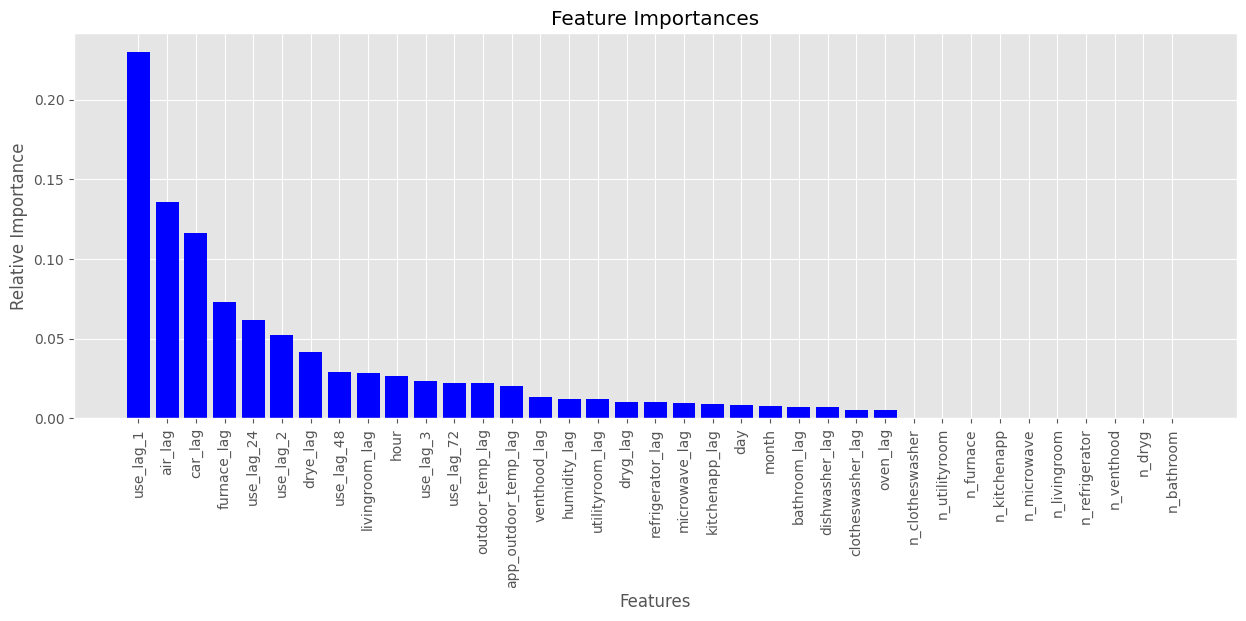

In [103]:
# Feature Labels
feature_labels = train_X.columns

# Extrahieren des RandomForestRegressor aus dem besten Modell
best_rf = best_model.named_steps['regressor']

# Extrahieren der Feature-Importances
feature_importances = best_rf.feature_importances_

# Überprüfen, ob die Anzahl der Features übereinstimmt
if len(feature_labels) != len(feature_importances):
    raise ValueError("Die Anzahl der Features im Modell stimmt nicht mit der Anzahl der ursprünglichen Features überein.")
    
# Zuordnung der Feature-Namen
importance_df = pd.DataFrame({'feature': feature_labels, 'importance': feature_importances})
importance_df.sort_values(by='importance', ascending=False, inplace=True)

# Erstellen des Plots
plt.figure(figsize=(15, 5))
plt.title("Feature Importances")
plt.bar(importance_df.feature, importance_df.importance, color='b')
plt.xlabel('Features')
plt.ylabel('Relative Importance')
plt.xticks(rotation=90)
plt.show()

<a id="5"></a>
## 3. Erstellung eines XGBoost-Modells
https://www.kaggle.com/code/prashant111/a-guide-on-xgboost-hyperparameters-tuning

In [104]:
pipeline_xgb = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('regressor', XGBRegressor(random_state=1))
])

param_grid_xgb = {
    'regressor__learning_rate': [0.01, 0.1, 0.2, 0.3],
    'regressor__n_estimators': [100, 200, 300, 400],
    'regressor__max_depth': [3, 4, 5, 6],
    'regressor__min_child_weight': [1, 2, 3, 4],
    'regressor__gamma': [0, 0.1, 0.2, 0.3],
    'regressor__subsample': [0.7, 0.8, 0.9, 1.0],
    'regressor__colsample_bytree': [0.7, 0.8, 0.9, 1.0]
}

xgb = RandomizedSearchCV(estimator=pipeline_xgb, param_distributions=param_grid_xgb, n_iter=100, cv=3, verbose=0, random_state=1, n_jobs = -1)

xgb.fit(train_X, train_y)

best_model_xgb = xgb.best_estimator_

predictions_xgb = best_model_xgb.predict(test_X)

print_metrics(test_y, predictions_xgb)

MAE: 0.44, RMSE: 0.7, MAPE: 63.78 %


<a id="6"></a>
## 4. Performance-Vergleich von ARIMA, Random Forest und XGBoost

In [105]:
df_comp = pd.DataFrame(test_y)
df_comp.reset_index(inplace=True)
df_comp.rename(columns={'use': 'actual'}, inplace=True)
df_comp['predicted_rf'] = predictions
df_comp['predicted_xgb'] = predictions_xgb
df_comp.sample(5)

,timestamp,actual,predicted_rf,predicted_xgb
453,2018-11-08 03:00:00,1.17050,1.437473,1.574945
217,2018-10-29 07:00:00,0.56875,0.672659,0.789805
1718,2018-12-30 20:00:00,3.14525,1.068322,1.000542
1298,2018-12-13 08:00:00,0.38725,0.913033,0.906892
1001,2018-11-30 23:00:00,1.09000,2.097007,1.736832


In [106]:
arima_predictions = pd.read_csv("../input/2024-01-13/arima_1642.csv")
arima_predictions.timestamp = pd.to_datetime(arima_predictions.timestamp)
df_comp_ext = pd.merge(df_comp, arima_predictions, on='timestamp', how='right') # Da aktuell nur 200 Einträge, wird ein right Join gemacht
df_comp_ext.head()

,timestamp,actual,predicted_rf,predicted_xgb,predicted_arima
0,2018-12-23 22:00:00,3.95325,1.908038,2.385128,1.314593
1,2018-12-23 23:00:00,3.35800,2.704922,2.992243,1.105473
2,2018-12-24 00:00:00,1.31350,1.709724,1.408746,0.958520
3,2018-12-24 01:00:00,0.71050,1.462298,1.286946,0.961658
4,2018-12-24 02:00:00,1.01575,1.093357,1.088103,1.089727


In [107]:
# datapoints_week = 24 * 7
# last_start_idx = len(df_comp) - datapoints_week - 1
# start_idx = random.randint(0, last_start_idx)
# end_idx = start_idx + datapoints_week
# df_plot = df_comp[start_idx:end_idx]

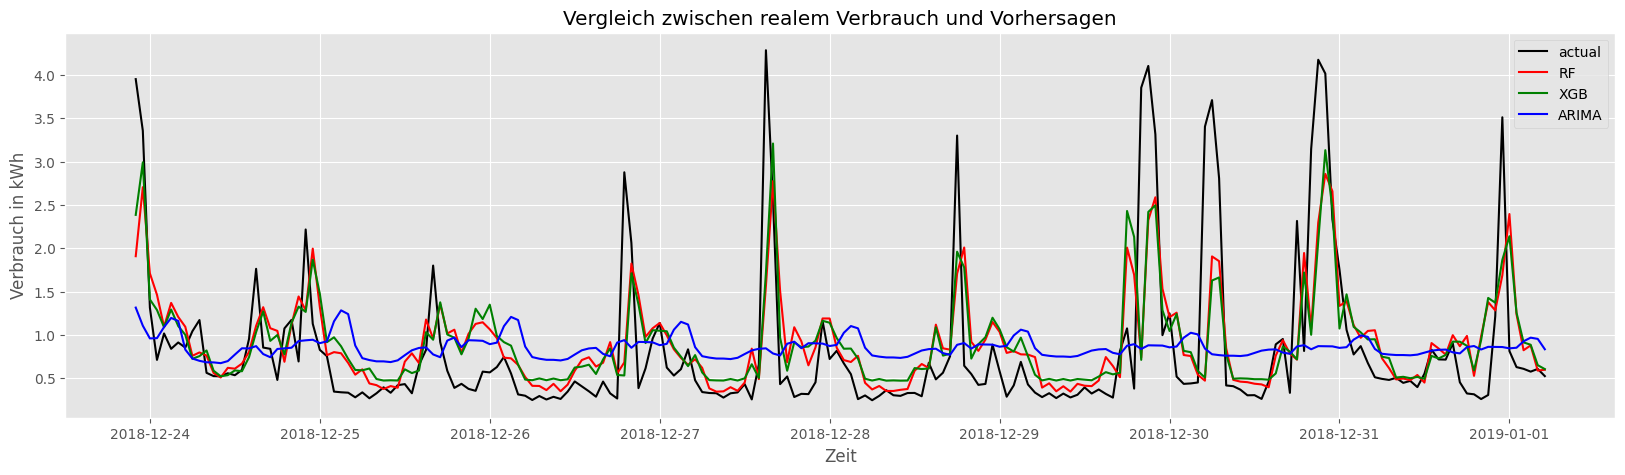

In [108]:
plt.figure(figsize=(20, 5))
plt.plot(df_comp_ext.timestamp, df_comp_ext.actual, color='black', label='actual')
plt.plot(df_comp_ext.timestamp, df_comp_ext.predicted_rf, color='red', label='RF')
plt.plot(df_comp_ext.timestamp, df_comp_ext.predicted_xgb, color='green', label='XGB')
plt.plot(df_comp_ext.timestamp, df_comp_ext.predicted_arima, color='blue', label='ARIMA')
plt.title('Vergleich zwischen realem Verbrauch und Vorhersagen')
plt.xlabel('Zeit')
plt.ylabel('Verbrauch in kWh')
plt.legend()
plt.show()

<a id="7"></a>
## 5. Weitere Modelle testen
https://unit8co.github.io/darts/README.html#forecasting-models

In [109]:
def plot_model_performance(preds):
    df1 = pd.DataFrame(test_y)
    df1.reset_index(inplace=True)
    df1.rename(columns={'use': 'actual'}, inplace=True)
    df1['predicted'] = preds

    df1 = df1.head(200)

    plt.figure(figsize=(20, 5))
    plt.plot(df1.timestamp, df1.actual, color='black', label='actual')
    plt.plot(df1.timestamp, df1.predicted, color='red', label='predictions')
    plt.title('Vergleich zwischen realem Verbrauch und Vorhersagen')
    plt.xlabel('Zeit')
    plt.ylabel('Verbrauch in kWh')
    plt.legend()
    plt.show()

In [110]:
from sklearn.linear_model import LinearRegression

pipeline_lr = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('regressor', LinearRegression())
])

pipeline_lr.fit(train_X, train_y)
lr_predictions = pipeline_lr.predict(test_X)
print_metrics(test_y, lr_predictions)

MAE: 0.43, RMSE: 0.74, MAPE: 51.74 %


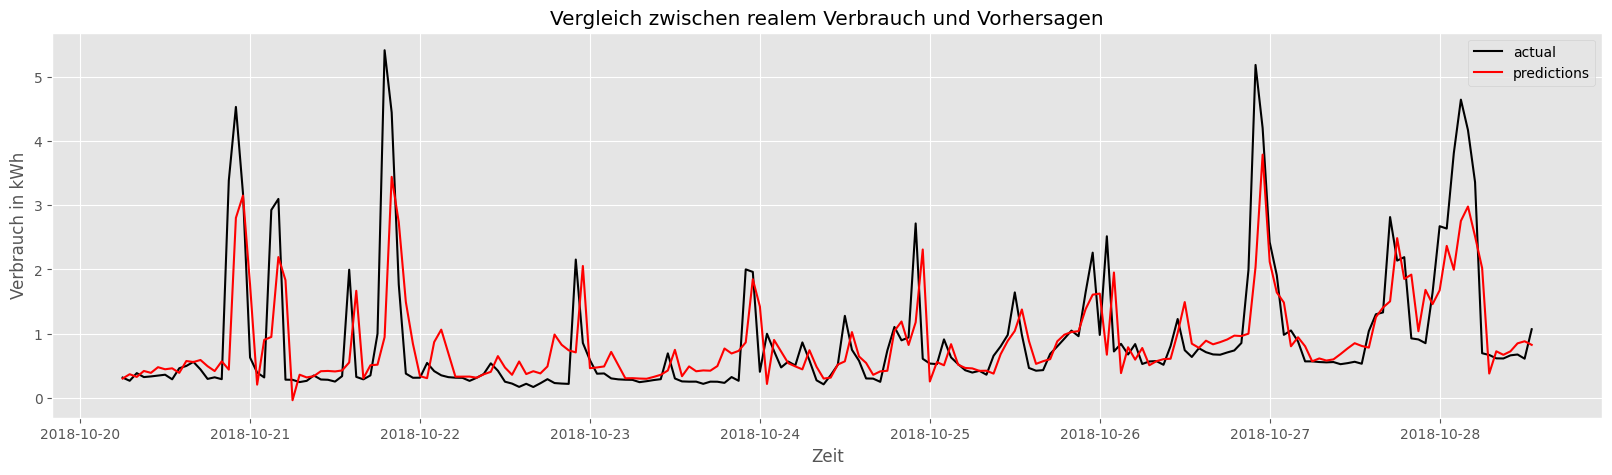

In [111]:
plot_model_performance(lr_predictions)

In [112]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense

# Imputationsschritt
imputer = SimpleImputer(strategy='median')
train_X_imputed = imputer.fit_transform(train_X)
test_X_imputed = imputer.transform(test_X)

# Umformen der Daten für das RNN (Beispiel: [Samples, Time Steps, Features])
train_X_reshaped = train_X_imputed.reshape((train_X_imputed.shape[0], 1, train_X_imputed.shape[1]))
test_X_reshaped = test_X_imputed.reshape((test_X_imputed.shape[0], 1, test_X_imputed.shape[1]))

# Erstellen des RNN-Modells
model = Sequential()
model.add(SimpleRNN(50, activation='relu', input_shape=(1, train_X_imputed.shape[1])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Trainieren des Modells
model.fit(train_X_reshaped, train_y, epochs=10, batch_size=32) #100 epochs eign

# Vorhersagen für Testdaten
predictions_rnn = model.predict(test_X_reshaped)

# Bewertung des Modells
# Ersetzen Sie 'print_metrics' durch Ihre Bewertungsfunktion
print_metrics(test_y, predictions_rnn)

Epoch 1/10
219/219 [==============================] - 2s 2ms/step - loss: 2.4049
Epoch 2/10
219/219 [==============================] - 0s 2ms/step - loss: 0.7449
Epoch 3/10
219/219 [==============================] - 1s 2ms/step - loss: 0.6997
Epoch 4/10
219/219 [==============================] - 1s 2ms/step - loss: 0.6850
Epoch 5/10
219/219 [==============================] - 1s 2ms/step - loss: 0.6760
Epoch 6/10
219/219 [==============================] - 1s 2ms/step - loss: 0.6836
Epoch 7/10
219/219 [==============================] - 1s 3ms/step - loss: 0.6539
Epoch 8/10
219/219 [==============================] - 1s 2ms/step - loss: 0.6598
Epoch 9/10
219/219 [==============================] - 1s 3ms/step - loss: 0.6524
Epoch 10/10
55/55 [==============================] - 0s 2ms/step
MAE: 0.46, RMSE: 0.77, MAPE: 58.73 %


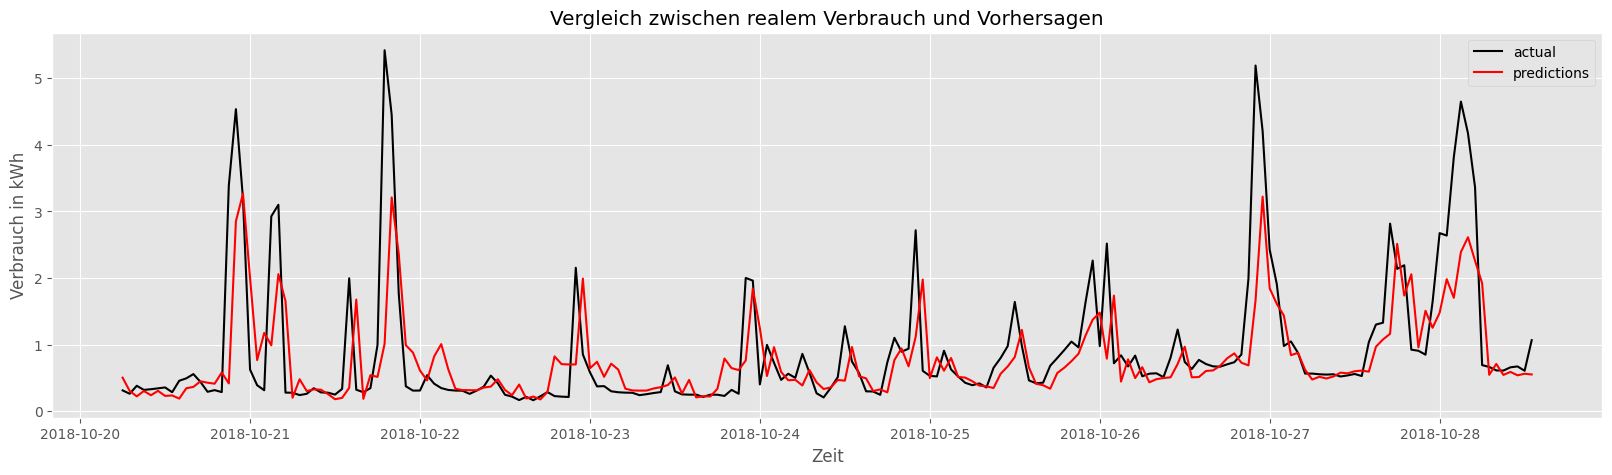

In [113]:
plot_model_performance(predictions_rnn)

### To-do:
* Habe ich Schritte vergessen?
* Passt Reihenfolge?
* Welche Modelle wählen?
* Warum ist Performance so schlecht?
* Data Leakage? ... Lags
* Modellauswahl --> RNN passt nicht dazu